In [92]:
import pandas as pd
import urllib

import numpy as np

import json

from tqdm.autonotebook import tqdm

#%matplotlib inline

tqdm.pandas()

import dask.dataframe as dd

from dask.multiprocessing import get
from dask.diagnostics import ProgressBar

from datetime import datetime
import matplotlib.pyplot as plt

from IPython.display import display


In [93]:
import requests

In [94]:
# import urllib3

In [95]:
# http = urllib3.PoolManager()

# Functions

In [96]:
ws_hostname = "127.0.1.1"
ws_hostname = "172.27.0.64"


street_field  = "streetName"
housenbr_field = "houseNumber"
postcode_field = "postCode"
city_field  =    "postName"
country_field =  "countryName"
addr_key_field = "addrKey"

# ws_hostname = "192.168.1.3"

In [97]:

sample_size = None# 1000
def get_addresses(addresses_filename):
    addresses = pd.read_csv(addresses_filename,  
                            usecols = lambda x: x in [addr_key_field, "addr_key",
                                       country_field, 
                                       postcode_field, 
                                       city_field, 
                                       street_field, 
                                       housenbr_field,
                                       country_field], 
                           dtype={postcode_field: str, housenbr_field: str, country_field: str})
    
    
    addresses = addresses.rename(columns={"addr_key": addr_key_field})
    if country_field in addresses: 
        addresses[country_field] =addresses[country_field].fillna("Belgique")
    else: 
        addresses[country_field] = "Belgique"
    #addresses = addresses.rename(columns={"index":addr_key_field})
    
    addresses = addresses[addresses[street_field].notnull() & addresses[city_field].notnull()] # & addresses[country_field].isnull() ]
    
    addresses[postcode_field] = addresses[postcode_field].astype(str)
    
    if sample_size: 
        addresses = addresses.sample(sample_size, random_state=0)
    
    return addresses#.drop(country_field, axis=1)

In [98]:
def call_ws(addr_data, check_result=True, structured_osm=False, with_rejected=False, mode="long", extra_house_number=True): #lg = "en,fr,nl"
    t = datetime.now()
    
    fields = { 
            "checkResult" : check_result,
            "structuredOsm" : structured_osm,
            "withRejected": with_rejected,
            "extraHouseNumber": extra_house_number,
            "mode": mode
        }

    if isinstance(addr_data, pd.Series):
        addr_data = addr_data.to_dict()
        
    data = {"address": addr_data    }

        
    try: 
        r = requests.post(
        f'http://{ws_hostname}:5000//REST/nominatimWrapper/v1/geocode',
            params=fields,
            json=data)
        

    except Exception as e:
        print("Exception !")
        print(addr_data)
        print(e)
        raise e
        
#     print(r)
    if r.status_code == 204:
        print("No result!")
        print(addr_data)
        print(r.text)
        return
    elif r.status_code == 400:
        print("Argument error")
        print(r.text)
    elif r.status_code == 200:
        try:
#            res = r.text
            res = json.loads(r.text)
            res["time"] = (datetime.now() - t).total_seconds()
        except ValueError as ve:

            print("Cannot decode result:")
            print(ve)
            print(r.text)
            return r.text
        return res
    else: 
        print(f"Unknown return code: {r.status_code} ")
        print(r.text)



In [99]:
def split_columns(addresses_batch):
    output = pd.DataFrame(index=addresses_batch.index, dtype=str)

    for f in addresses_batch:
#        print(f)
        grp= addresses_batch[f].apply(lambda r : pd.Series(r, dtype=str) if pd.notnull(r) else pd.Series(dtype=str)) 
        grp = pd.concat({f: grp}, names=['L0', 'L1'], axis=1)
        
        output = pd.concat([output, grp], axis=1)
    # display(output)
    output.columns = pd.MultiIndex.from_tuples(output.columns)
    return output  

In [100]:
def format_ws_res(addresses):
    # assert addresses.json.apply(lambda js: "match" in js).all()
    assert addresses.json.apply(lambda js: len(js["match"])==1 if js is not None and "match" in js else True).all()
    addresses_out = addresses.json.apply(lambda js: pd.Series(js["match"][0]) if js is not None and "match" in js else pd.Series(dtype=object))
    #reject_out = addresses.json.apply(lambda js: pd.Series(js["rejected"][0]) if js is not None and "rejected" in js else pd.Series(dtype=object))
    
    addresses_out =  split_columns(addresses_out)
    return addresses_out

In [101]:
def call_ws_batch(addr_data, mode="coordinates", with_rejected=False, check_result=True, structured_osm=False, extra_house_number=True): #lg = "en,fr,nl"
    #file_data = addr_data.to_csv(index=False)
    
    r = requests.post(
    f'http://{ws_hostname}:5000/REST/nominatimWrapper/v1/batchGeocode',
    params= { 
        'mode': mode,
        "withRejected": with_rejected,
        "checkResult" : check_result,
        "structuredOsm"   : structured_osm,
        "extraHouseNumber": extra_house_number
    },
    json={"addresses": addr_data.fillna('').to_dict(orient="records")}
    )
    
    if r.status_code == 204:
        print("No result!")
        print(addr_data)
        print(r.text)
        return None, None
    elif r.status_code == 400:
        print("Argument error")
        print(r.text)
        return None, None
    elif r.status_code == 200:
        
        try:

            res_json = json.loads(r.text)
            if "match" in res_json:
                match =  split_columns(pd.DataFrame(res_json["match"]))
                rejected= split_columns(pd.DataFrame(res_json["rejected"])) if "rejected" in res_json and len(res_json["rejected"])>0 else pd.DataFrame()

            else :
                match =  split_columns(pd.DataFrame(res_json))
                rejected=None
        except ValueError as ve:

            print("Cannot decode result:")
            print(ve)
            print(r.text)

            return r.text, None
    
    return match, rejected 
    


# Calls

## Single address calls

In [102]:
res=call_ws({
#         addr_key_field: 5,
        street_field:   "Avenue Fonsny", \
         housenbr_field: "20",\
         city_field:     "Saint-Gilles",\
         postcode_field: "1060",\
         country_field:  "Belgique"}, check_result=False, structured_osm=True, with_rejected=False, mode="long")
res

{'match': [{'metadata': {'method': 'fast',
    'addrKey': '-1',
    'placeRank': '30',
    'placeId': '182128',
    'transformedAddress': 'Avenue Fonsny, 20, 1060 Saint-Gilles, Belgique',
    'osmOrder': 0},
   'output': {'streetName': 'Avenue Fonsny - Fonsnylaan',
    'houseNumber': '20',
    'postCode': '1060',
    'postName': 'Saint-Gilles - Sint-Gillis',
    'countryName': 'België / Belgique / Belgien',
    'displayName': '20, Avenue Fonsny - Fonsnylaan, Saint-Gilles - Sint-Gillis, Brussel-Hoofdstad - Bruxelles-Capitale, Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest, 1060, België / Belgique / Belgien',
    'libpostalHouseNumber': ['20', ''],
    'lat': 50.8358677,
    'lon': 4.3385087},
   'check': {}}],
 'time': 0.030474}

In [103]:
res=call_ws({
#         addr_key_field: 5
         "fullAddress" : "Avenue Fonsy 20, 1060 Bruxelles",
         street_field:   "Avenue Fonsny", \
         housenbr_field: "20",\
         city_field:     "Saint-Gilles",\
         postcode_field: "1060",\
         country_field:  "Belgique"
}, check_result=True, structured_osm=False, with_rejected=False, mode="long")
res

Argument error
{"message": "Field 'fullAddress' cannot be used together with fields postCode;houseNumber;postName;countryName;streetName"}



In [104]:
res=call_ws({

    addr_key_field: 5,
    street_field:   "Avenue Fonsny", \
         housenbr_field: "20",\
         city_field:     "Saint-Gilles",\
         postcode_field: "1060",\
         country_field:  "Belgique"}, check_result=True, structured_osm=True, with_rejected=True, extra_house_number=True)
res

{'match': [{'metadata': {'method': 'orig',
    'addrKey': '5',
    'placeRank': '30',
    'placeId': '182128',
    'transformedAddress': 'Avenue Fonsny, 20, 1060 Saint-Gilles, Belgique',
    'osmOrder': 0},
   'output': {'streetName': 'Avenue Fonsny - Fonsnylaan',
    'houseNumber': '20',
    'postCode': '1060',
    'postName': 'Saint-Gilles - Sint-Gillis',
    'countryName': 'België / Belgique / Belgien',
    'displayName': '20, Avenue Fonsny - Fonsnylaan, Saint-Gilles - Sint-Gillis, Brussel-Hoofdstad - Bruxelles-Capitale, Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest, 1060, België / Belgique / Belgien',
    'other': 'Brussel-Hoofdstad - Bruxelles-Capitale',
    'libpostalHouseNumber': ['20', ''],
    'lat': 50.8358677,
    'lon': 4.3385087},
   'check': {'simStreetWhich': 'street_name',
    'simStreet': 1.0,
    'simCity': 0.46153846153846156,
    'simPostCode': 1.0,
    'simHouseNumber': 1.0}}],
 'rejected': [{'metadata': {'method': 'orig',
    'addrKey': '5',
    'p

## Batch calls (row by row)

In [105]:
addresses = pd.concat([
   get_addresses("data/address_restobe.csv.gz").assign(dataset="resto"),
   get_addresses("data/address_best.csv.gz").assign(dataset="best"),
   get_addresses("data/address_cbe.csv.gz").assign(dataset="cbe")
])
addresses = addresses.reset_index(drop=True)
addresses[addr_key_field] = addresses.index.astype(str)
addresses

,addrKey,streetName,houseNumber,postName,postCode,countryName,dataset
0,0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto
1,1,Rue de la Halle,11,NAMUR,5000,Belgique,resto
2,2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto
3,3,rue du Centre,200,WAIMES,4950,Belgique,resto
4,4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto
...,...,...,...,...,...,...,...
2995,2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe
2996,2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe
2997,2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe
2998,2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe


In [106]:
# addresses = addresses.sample(100)

In [107]:
# addresses = pd.read_csv("data/address_bad.csv")
# addresses
iter_per_sec_stats={}


### Simple way

In [108]:
# addresses = addresses[addresses.streetName.str.lower().str.contains("steenweg op antwerpen")]

# # addresses = addresses.loc[[100,112,118,142,155,179,198]]
# # addresses = addresses.loc[[ 94,  100,  198, ]]
# addresses = addresses.loc[0:100]
# addresses

In [109]:
addresses_seq = addresses.copy()

t = datetime.now()
addresses_seq["json"] = addresses_seq.fillna("").progress_apply(call_ws, check_result=False, 
                                                                structured_osm=False, 
                                                                with_rejected=True, 
                                                                mode="short",axis=1)
tot_time = (datetime.now() - t).total_seconds()

ips=addresses_seq.shape[0]/tot_time
iter_per_sec_stats["sequential"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")


# KBO dataset:
# Normal mode: 128.78 seconds, 7.77 it/s
# Fastmode:     68.80 seconds, 14.54 it/s

#Resto dataset: 
# Normal mode: 145.73 seconds, 6.86 it/s
# Fast mode:    82.99 seconds, 12.05 it/s

# Best dataset:
# Normal mode: 108.53 seconds, 9.21 it/s
# Fast mode: 37.44 seconds, 26.71 it/s

addresses_seq

  0%|          | 0/100 [00:00<?, ?it/s]

6.76 seconds, 14.79 it/s


,addrKey,streetName,houseNumber,postName,postCode,countryName,dataset,json
2465,2465,Rue Victor Allard,293,Uccle,1180,Belgique,cbe,"{'match': [{'metadata': {'method': 'fast', 'ad..."
380,380,Rue Juste Lipse,17,BRUXELLES CENTRE,1000,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
2788,2788,Steenweg,245,Nazareth,9810,Belgique,cbe,"{'match': [{'metadata': {'method': 'fast', 'ad..."
2412,2412,Pundershoekstraat,47,Hechtel-Eksel,3940,Belgique,cbe,"{'match': [{'metadata': {'method': 'fast', 'ad..."
2556,2556,17 A.H.HOLLEVOET,NaN,Molenbeek-Saint-Jean,1080,Belgique,cbe,{'match': [{'metadata': {'method': 'libpostal+...
...,...,...,...,...,...,...,...,...
430,430,Chaussée de Charleroi,41,SAINT-GILLES,1060,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
882,882,Chaussée du roi albert,8,ANS,4430,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
409,409,avenue Paul Dejaer,39,SAINT-GILLES,1060,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
2980,2980,Rue de Quevaucamps (Bas),19,Beloeil,7971,Belgique,cbe,{'match': [{'metadata': {'method': 'regex[init...


In [110]:
timing = addresses_seq[["dataset"]].copy()
timing["time"] =addresses_seq.json.apply(lambda j: j["time"] if j else None) 
timing["method"] =addresses_seq.json.apply(lambda j: j["match"][0]["metadata"]["method"] if j else None) 

timing

,dataset,time,method
2465,cbe,0.041728,fast
380,resto,0.030083,fast
2788,cbe,0.142819,fast
2412,cbe,0.035821,fast
2556,cbe,0.219436,libpostal+regex[lpost]
...,...,...,...
430,resto,0.041703,fast
882,resto,0.022735,fast
409,resto,0.022506,fast
2980,cbe,0.185123,regex[init]


<AxesSubplot:title={'center':'Avg call duration'}, xlabel='dataset'>

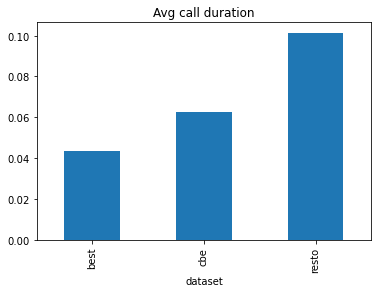

In [111]:
(timing.groupby("dataset").time.mean()).plot.bar(title="Avg call duration")

<AxesSubplot:title={'center':'Avg call duration'}, xlabel='method'>

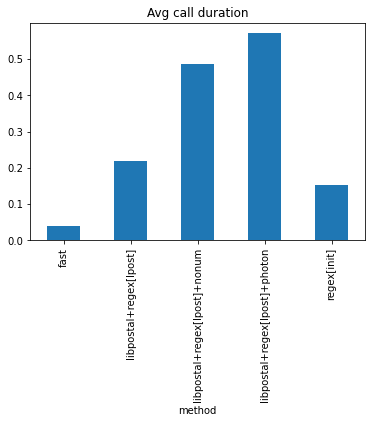

In [112]:
(timing.groupby("method").time.mean()).plot.bar(title="Avg call duration")

<AxesSubplot:xlabel='dataset'>

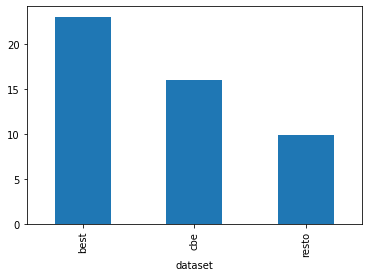

In [113]:
(1/timing.groupby("dataset").time.mean()).plot.bar("Iterations per seconds")

dataset
best     AxesSubplot(0.125,0.125;0.775x0.755)
cbe      AxesSubplot(0.125,0.125;0.775x0.755)
resto    AxesSubplot(0.125,0.125;0.775x0.755)
Name: time, dtype: object

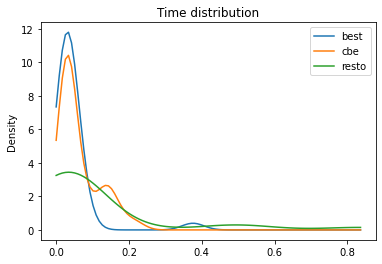

In [114]:
timing.groupby("dataset").time.plot.kde(legend=True, ind=np.linspace(0,timing.time.max(), 100 ), title="Time distribution" )

method
fast                             AxesSubplot(0.125,0.125;0.775x0.755)
libpostal+regex[lpost]+photon    AxesSubplot(0.125,0.125;0.775x0.755)
regex[init]                      AxesSubplot(0.125,0.125;0.775x0.755)
Name: time, dtype: object

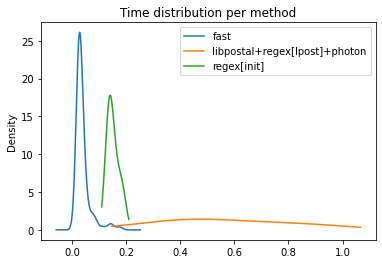

In [115]:
mthd_vc= timing.method.value_counts()
mthd_vc[mthd_vc==1]
timing[~timing.method.isin(mthd_vc[mthd_vc==1].index)][["method", "time"]].groupby("method").time.plot.kde(legend=True, title="Time distribution per method" )

<AxesSubplot:title={'center':'time'}, xlabel='[dataset]'>

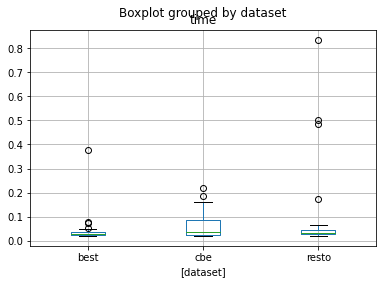

In [116]:
timing[["time", "dataset"]].boxplot(by="dataset")#.boxplot()

<AxesSubplot:title={'center':'Iterations per second'}>

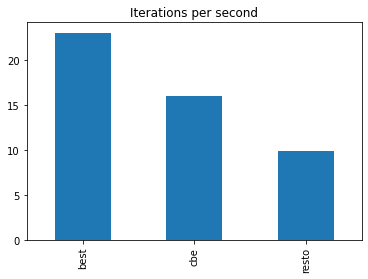

In [117]:
(timing.dataset.value_counts()/timing.groupby("dataset").time.sum()).plot.bar(title="Iterations per second")

In [118]:
addresses_seq_out = format_ws_res(addresses_seq)
addresses_seq_out

metadata                    \
                      method addrKey placeRank   
2465                    fast    2465        30   
380                     fast     380        30   
2788                    fast    2788        26   
2412                    fast    2412        30   
2556  libpostal+regex[lpost]    2556        30   
...                      ...     ...       ...   
430                     fast     430        30   
882                     fast     882        30   
409                     fast     409        30   
2980             regex[init]    2980        26   
1714                    fast    1714        30   

                                            output                       \
                                        streetName houseNumber postCode   
2465       Rue Victor Allard - Victor Allardstraat         293     1180   
380         Rue Juste Lipse - Justus Lipsiusstraat          17     1040   
2788                                      Steenweg         NaN     9810   
2412                             Pundershoekstraat       47-49     3940   
2556      Rue des Quatre-Vents - Vier-windenstraat          17     1080   
...                                            ...         ...      ...   
430   Chaussée de Charleroi - Charleroise Steenweg          41     1060   
882                         Chaussée du Roi Albert           8     4430   
409           Avenue Paul Dejaer - Paul Dejaerlaan          39     1060   
2980                            Rue de Quevaucamps         NaN     7971   
1714                     Lange Van Ruusbroecstraat          37     2018   

                                                                               \
                                        postName                  countryName   
2465                               Uccle - Ukkel  België / Belgique / Belgien   
380                          Bruxelles - Brussel  België / Belgique / Belgien   
2788                                         Eke  België / Belgique / Belgien   
2412                               Hechtel-Eksel  België / Belgique / Belgien   
2556  Molenbeek-Saint-Jean - Sint-Jans-Molenbeek  België / Belgique / Belgien   
...                                          ...                          ...   
430                   Saint-Gilles - Sint-Gillis  België / Belgique / Belgien   
882                                          Ans  België / Belgique / Belgien   
409                   Saint-Gilles - Sint-Gillis  België / Belgique / Belgien   
2980                                    Basècles  België / Belgique / Belgien   
1714                                   Antwerpen  België / Belgique / Belgien   

                                                                              \
                                            displayName libpostalHouseNumber   
2465  293, Rue Victor Allard - Victor Allardstraat, ...          ['293', '']   
380   17, Rue Juste Lipse - Justus Lipsiusstraat, Qu...           ['17', '']   
2788  Steenweg, Eke, Nazareth, Gent, Oost-Vlaanderen...          ['245', '']   
2412  47-49, Pundershoekstraat, Eksel, Hechtel-Eksel...           ['47', '']   
2556  17, Rue des Quatre-Vents - Vier-windenstraat, ...           ['17', '']   
...                                                 ...                  ...   
430   41, Chaussée de Charleroi - Charleroise Steenw...           ['41', '']   
882   8, Chaussée du Roi Albert, Loncin, Ans, Liège,...            ['8', '']   
409   39, Avenue Paul Dejaer - Paul Dejaerlaan, Ma C...           ['39', '']   
2980  Rue de Quevaucamps, Basècles, Belœil, Ath, Hai...           ['19', '']   
1714  37, Lange Van Ruusbroecstraat, Zurenborg, Antw...           ['37', '']   

                                      \
              lat                lon   
2465  50.80273855  4.324424239705814   
380    50.8403742          4.3816743   
2788   50.9566699          3.6415525   
2412   51.1533393  5.381670612727994   
2556  50.85504665  4.334338421869676   
...           ... 

In [119]:
# addresses_seq_out[addresses_seq_out[("output", "lat")].isnull()]

In [120]:
# rejected_seq_out = format_ws_res(rejected)
# rejected_seq_out

rejected = addresses_seq.json.apply(lambda js: pd.Series(js["rejected"]) if js is not None and "rejected" in js and len(js["rejected"])>0 else pd.Series(dtype=object))
rejected = rejected.unstack().dropna()
rejected = split_columns(rejected.apply(pd.Series))
rejected

metadata                                 \
                               method addrKey placeRank rejectReason   
0 722                            fast     722        26         tail   
  667                            fast     667        30         tail   
  364                            fast     364        30         tail   
  998                            fast     998        30         tail   
  1582                           fast    1582        26         tail   
  2546                           fast    2546        26         tail   
  2393                           fast    2393        26         tail   
  267                            fast     267        30         tail   
  2333                           fast    2333        26         tail   
  2655                           fast    2655        30         tail   
  2280                    regex[init]    2280        30         tail   
  579                            fast     579        30         tail   
  1170                           fast    1170        26         tail   
  729                            fast     729        30         tail   
  1269                           fast    1269        26         tail   
  99    libpostal+regex[lpost]+photon      99      30.0         tail   
  263                            fast     263        26         tail   
  264                            fast     264        26         tail   
  1399                           fast    1399        30         tail   
  2859                           fast    2859        26         tail   
  2930                           fast    2930        30         tail   
  15                             fast      15        30         tail   
1 722                            fast     722        30         tail   
  364                            fast     364        30         tail   
  2546                           fast    2546        26         tail   
  2393                           fast    2393        27         tail   
  267                            fast     267        30         tail   
  2333                           fast    2333        26         tail   
  2655                           fast    2655        30         tail   
  1269                           fast    1269        26         tail   
  1399                           fast    1399        30         tail   
  2859                           fast    2859        26         tail   
2 722                            fast     722        30         tail   
  364                            fast     364        30         tail   
  2546                           fast    2546        26         tail   
  2393                           fast    2393        30         tail   
  267                            fast     267        30         tail   
  2333                           fast    2333        26         tail   
  2859                           fast    2859        26         tail   
3 722                            fast     722        30         tail   
  2546                           fast    2546        26         tail   
  2333                           fast    2333        26         tail   
4 722                            fast     722        30         tail   
  2546                           fast    2546        30         tail   
  2333                           fast    2333        27         tail   
5 722                            fast     722        30         tail   
  2333                           fast    2333        27         tail   
6 722                            fast     722        26         tail   
7 722                            fast     722        26         tail   

                                                              output           \
       distanceToMatch                                    streetName postCode   
0 722            0.053                              Mechelsesteenweg     2000   
  667            0.002  Place Sainte-Catherine - Sint-Katelijneplein     1000   
  364            0.006          

In [121]:
addresses_seq_out[addresses_seq_out[("metadata", "addrKey")] == "443"]

Empty DataFrame
Columns: [(metadata, method), (metadata, addrKey), (metadata, placeRank), (output, streetName), (output, houseNumber), (output, postCode), (output, postName), (output, countryName), (output, displayName), (output, libpostalHouseNumber), (output, lat), (output, lon), (output, other)]
Index: []

In [122]:
# addresses_seq_out[addresses_seq_out[("metadata", "retryOn26")] =="True"]

In [124]:
addresses_seq_out[("metadata", "method")].value_counts(dropna=False)

fast                             90
regex[init]                       5
libpostal+regex[lpost]+photon     3
libpostal+regex[lpost]            1
libpostal+regex[lpost]+nonum      1
Name: (metadata, method), dtype: int64

In [125]:
# addresses_seq_out[addresses_seq_out[("work", 0)].isnull()]
addresses_seq_out[addresses_seq_out[("metadata", "method")] != "fast"]

metadata                    \
                             method addrKey placeRank   
2556         libpostal+regex[lpost]    2556        30   
2581                    regex[init]    2581        30   
2718                    regex[init]    2718        26   
925   libpostal+regex[lpost]+photon     925        30   
1889  libpostal+regex[lpost]+photon    1889        30   
2280                    regex[init]    2280        30   
432    libpostal+regex[lpost]+nonum     432        21   
99    libpostal+regex[lpost]+photon      99        30   
2623                    regex[init]    2623        30   
2980                    regex[init]    2980        26   

                                         output                       \
                                     streetName houseNumber postCode   
2556   Rue des Quatre-Vents - Vier-windenstraat          17     1080   
2581                                Herenstraat          36     9170   
2718                            Terwarentstraat         NaN     9451   
925                     Place du Roi Albert 1er           3     4300   
1889                         Jules de Troozlaan          33     8370   
2280                              Essensteenweg          82     2920   
432                                         NaN         NaN     2860   
99    Place Reine Astrid - Koningin Astridplein          34     1090   
2623                            Route de Hannut         261     5021   
2980                         Rue de Quevaucamps         NaN     7971   

                                                                               \
                                        postName                  countryName   
2556  Molenbeek-Saint-Jean - Sint-Jans-Molenbeek  België / Belgique / Belgien   
2581                            Sint-Gillis-Waas  België / Belgique / Belgien   
2718                                    Kerksken  België / Belgique / Belgien   
925                                      Waremme  België / Belgique / Belgien   
1889                                Blankenberge  België / Belgique / Belgien   
2280                                   Kalmthout  België / Belgique / Belgien   
432                         Sint-Katelijne-Waver  België / Belgique / Belgien   
99                                         Jette  België / Belgique / Belgien   
2623                                     Boninne  België / Belgique / Belgien   
2980                                    Basècles  België / Belgique / Belgien   

                                                                              \
                                            displayName libpostalHouseNumber   
2556  17, Rue des Quatre-Vents - Vier-windenstraat, ...           ['17', '']   
2581  36, Herenstraat, Sint-Gillis-Waas, Sint-Niklaa...           ['36', '']   
2718  Terwarentstraat, Kerksken, Haaltert, Aalst, Oo...             ['', '']   
925   3, Place du Roi Albert 1er, Petit-Axhe, Waremm...            ['3', '']   
1889  33, Jules de Troozlaan, Westkwartier, Blankenb...           ['33', '']   
2280  82, Essensteenweg, Nieuwmoer, Kalmthout, Antwe...           ['82', '']   
432   Sint-Katelijne-Waver, Mechelen, Antwerpen, Vla...           ['27', '']   
99    Wine in the City, 34, Place Reine Astrid - Kon...           ['34', '']   
2623  261, Route de Hannut, Boninne, Namur, Wallonie...          ['261', '']   
2980  Rue de Quevaucamps, Basècles, Belœil, Ath, Hai...           ['19', '']   

                                              \
                     lat                 lon   
2556         50.85504665   4.334338421869676   
2581           51.222889   4.120912504868171   
2718          50.8783308            3.975205   
925   50.696132399999996   5.253812849603943   
1889   51.31524855000001  3.1337079613944265   
2280  51.439400500000005   4.505736371175095   
432    51.05194887746337   4.501336732150135   
99            50.8723091           4.3241471   
2623  50.496678450000005   4.934897061791812   
2980          5

In [127]:
# call_ws(addresses_seq.loc[700], check_result=False, with_rejected=False)

In [128]:
# call_ws(addresses_seq.loc[4], check_result=False, with_rejected=True)

In [129]:
# addresses_seq_out[addresses_seq.json.apply(lambda js: "osmOrder" in js["match"][0]['work'] if js else None).fillna(False)]

In [130]:
addresses_seq

,addrKey,streetName,houseNumber,postName,postCode,countryName,dataset,json
2465,2465,Rue Victor Allard,293,Uccle,1180,Belgique,cbe,"{'match': [{'metadata': {'method': 'fast', 'ad..."
380,380,Rue Juste Lipse,17,BRUXELLES CENTRE,1000,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
2788,2788,Steenweg,245,Nazareth,9810,Belgique,cbe,"{'match': [{'metadata': {'method': 'fast', 'ad..."
2412,2412,Pundershoekstraat,47,Hechtel-Eksel,3940,Belgique,cbe,"{'match': [{'metadata': {'method': 'fast', 'ad..."
2556,2556,17 A.H.HOLLEVOET,NaN,Molenbeek-Saint-Jean,1080,Belgique,cbe,{'match': [{'metadata': {'method': 'libpostal+...
...,...,...,...,...,...,...,...,...
430,430,Chaussée de Charleroi,41,SAINT-GILLES,1060,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
882,882,Chaussée du roi albert,8,ANS,4430,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
409,409,avenue Paul Dejaer,39,SAINT-GILLES,1060,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
2980,2980,Rue de Quevaucamps (Bas),19,Beloeil,7971,Belgique,cbe,{'match': [{'metadata': {'method': 'regex[init...


### Using Dask

In [131]:
addresses_dask = addresses.copy()

In [132]:
addresses_dask

,addrKey,streetName,houseNumber,postName,postCode,countryName,dataset
2465,2465,Rue Victor Allard,293,Uccle,1180,Belgique,cbe
380,380,Rue Juste Lipse,17,BRUXELLES CENTRE,1000,Belgique,resto
2788,2788,Steenweg,245,Nazareth,9810,Belgique,cbe
2412,2412,Pundershoekstraat,47,Hechtel-Eksel,3940,Belgique,cbe
2556,2556,17 A.H.HOLLEVOET,NaN,Molenbeek-Saint-Jean,1080,Belgique,cbe
...,...,...,...,...,...,...,...
430,430,Chaussée de Charleroi,41,SAINT-GILLES,1060,Belgique,resto
882,882,Chaussée du roi albert,8,ANS,4430,Belgique,resto
409,409,avenue Paul Dejaer,39,SAINT-GILLES,1060,Belgique,resto
2980,2980,Rue de Quevaucamps (Bas),19,Beloeil,7971,Belgique,cbe


In [133]:
t = datetime.now()
dd_addresses = dd.from_pandas(addresses_dask.fillna(""), npartitions=8)

dask_task = dd_addresses.apply(call_ws, check_result=False, meta=('x', 'str'), axis=1)

with ProgressBar(): 
    addresses_dask["json"] = dask_task.compute()
    

tot_time = (datetime.now() - t).total_seconds()

ips=addresses_dask.shape[0]/tot_time
iter_per_sec_stats["dask"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")

# KBO dataset:
# Normal mode: 24.52 seconds, 40.79 it/s
# Fastmode:    15.81 seconds, 63.27 it/s


# Resto dataset:
# Normal mode: 27.86 seconds, 35.89 it/s
# Fast mode:   18.44 seconds, 54.23 it/s

# Best dataset: 
# Normal mode: 16.11 seconds, 62.07 it/s
# Fast mode:    9.76 seconds, 102.42 it/s

[########################################] | 100% Completed |  1.4s
1.43 seconds, 69.69 it/s


In [134]:
# 1000, 1 worker: 4m18
# 4 workers, npart=4 : 1m20
# 8 workers, npart=4 : 1m20
# 8 workers, npart=8 : 44s

# with checker=False:
# 8 workers, npart=8 : 24s


In [135]:
# expand_json(addresses_dask)

addresses_dask_out = format_ws_res(addresses_dask)
addresses_dask_out

metadata                             \
                      method addrKey placeRank  placeId   
2465                    fast    2465        30  1104626   
380                     fast     380        30   227248   
2788                    fast    2788        26   945686   
2412                    fast    2412        30   464871   
2556  libpostal+regex[lpost]    2556        30  1105259   
...                      ...     ...       ...      ...   
430                     fast     430        30   195363   
882                     fast     882        30  3813827   
409                     fast     409        30   535409   
2980             regex[init]    2980        26   341949   
1714                    fast    1714        30  2042695   

                                                                  \
                                     transformedAddress osmOrder   
2465       Rue Victor Allard, 293, 1180 Uccle, Belgique        0   
380   Rue Juste Lipse, 17, 1000 BRUXELLES CENTRE, Be...        0   
2788             Steenweg, 245, 9810 Nazareth, Belgique        0   
2412  Pundershoekstraat, 47, 3940 Hechtel-Eksel, Bel...        0   
2556            17, 1080 molenbeek-saint-jean, belgique        0   
...                                                 ...      ...   
430   Chaussée de Charleroi, 41, 1060 SAINT-GILLES, ...        0   
882       Chaussée du roi albert, 8, 4430 ANS, Belgique        0   
409   avenue Paul Dejaer, 39, 1060 SAINT-GILLES, Bel...        0   
2980    Rue de Quevaucamps , 19, 7971 Beloeil, Belgique        0   
1714  Lange Van Ruusbroecstraat, 37, 2018 Anvers, Be...        0   

                                            output                       \
                                        streetName houseNumber postCode   
2465       Rue Victor Allard - Victor Allardstraat         293     1180   
380         Rue Juste Lipse - Justus Lipsiusstraat          17     1040   
2788                                      Steenweg         NaN     9810   
2412                             Pundershoekstraat       47-49     3940   
2556      Rue des Quatre-Vents - Vier-windenstraat          17     1080   
...                                            ...         ...      ...   
430   Chaussée de Charleroi - Charleroise Steenweg          41     1060   
882                         Chaussée du Roi Albert           8     4430   
409           Avenue Paul Dejaer - Paul Dejaerlaan          39     1060   
2980                            Rue de Quevaucamps         NaN     7971   
1714                     Lange Van Ruusbroecstraat          37     2018   

                                                                               \
                                        postName                  countryName   
2465                               Uccle - Ukkel  België / Belgique / Belgien   
380                          Bruxelles - Brussel  België / Belgique / Belgien   
2788                                         Eke  België / Belgique / Belgien   
2412                               Hechtel-Eksel  België / Belgique / Belgien   
2556  Molenbeek-Saint-Jean - Sint-Jans-Molenbeek  België / Belgique / Belgien   
...                                          ...                          ...   
430                   Saint-Gilles - Sint-Gillis  België / Belgique / Belgien   
882                                          Ans  België / Belgique / Belgien   
409                   Saint-Gilles - Sint-Gillis  België / Belgique / Belgien   
2980                                    Basècles  België / Belgique / Belgien   
1714                                   Antwerpen  België / Belgique / Belgien   

                                                                              \
                                            displayName libpostalHouseNumber   
2465  293, Rue Victor Allard - Victor Allardstraat, ...          ['293', '']   
380   17, Rue Juste Lipse - Justus Lipsiusstraat, Qu...           ['17', '']   
2788  Steenweg, E

In [136]:
fields = [("metadata", addr_key_field), ("metadata", "method"), ("output", city_field), ("output", postcode_field),("output", street_field), ("output", housenbr_field)]
mg = addresses_seq_out[fields].merge(
    addresses_dask_out[fields], how="outer", indicator=True)
if mg.shape[0] == addresses.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


/tmp/ipykernel_52253/615264633.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mg = addresses_seq_out[fields].merge(


In [137]:
mg

metadata                          \
    addrKey                  method   
0      2465                    fast   
1       380                    fast   
2      2788                    fast   
3      2412                    fast   
4      2556  libpostal+regex[lpost]   
..      ...                     ...   
95      430                    fast   
96      882                    fast   
97      409                    fast   
98     2980             regex[init]   
99     1714                    fast   

                                        output           \
                                      postName postCode   
0                                Uccle - Ukkel     1180   
1                          Bruxelles - Brussel     1040   
2                                          Eke     9810   
3                                Hechtel-Eksel     3940   
4   Molenbeek-Saint-Jean - Sint-Jans-Molenbeek     1080   
..                                         ...      ...   
95                  Saint-Gilles - Sint-Gillis     1060   
96                                         Ans     4430   
97                  Saint-Gilles - Sint-Gillis     1060   
98                                    Basècles     7971   
99                                   Antwerpen     2018   

                                                             _merge  
                                      streetName houseNumber         
0        Rue Victor Allard - Victor Allardstraat         293   both  
1         Rue Juste Lipse - Justus Lipsiusstraat          17   both  
2                                       Steenweg         NaN   both  
3                              Pundershoekstraat       47-49   both  
4       Rue des Quatre-Vents - Vier-windenstraat          17   both  
..                                           ...         ...    ...  
95  Chaussée de Charleroi - Charleroise Steenweg          41   both  
96                        Chaussée du Roi Albert           8   both  
97          Avenue Paul Dejaer - Paul Dejaerlaan          39   both  
98                            Rue de Quevaucamps         NaN   both  
99                     Lange Van Ruusbroecstraat          37   both  

[100 rows x 7 columns]

## Batch calls (batch WS)

### Single block

In [138]:
# addresses=addresses[addresses.addrKey.isin(["1075", "1331", "2616"])]
# addresses=addresses[addresses.addrKey.isin(["2206", "2556", "2569", "2715"])]
# addresses=addresses.iloc[0:10]
addresses


,addrKey,streetName,houseNumber,postName,postCode,countryName,dataset
2465,2465,Rue Victor Allard,293,Uccle,1180,Belgique,cbe
380,380,Rue Juste Lipse,17,BRUXELLES CENTRE,1000,Belgique,resto
2788,2788,Steenweg,245,Nazareth,9810,Belgique,cbe
2412,2412,Pundershoekstraat,47,Hechtel-Eksel,3940,Belgique,cbe
2556,2556,17 A.H.HOLLEVOET,NaN,Molenbeek-Saint-Jean,1080,Belgique,cbe
...,...,...,...,...,...,...,...
430,430,Chaussée de Charleroi,41,SAINT-GILLES,1060,Belgique,resto
882,882,Chaussée du roi albert,8,ANS,4430,Belgique,resto
409,409,avenue Paul Dejaer,39,SAINT-GILLES,1060,Belgique,resto
2980,2980,Rue de Quevaucamps (Bas),19,Beloeil,7971,Belgique,cbe


In [139]:
t = datetime.now()

addresses_batch, rejected = call_ws_batch(addresses[[addr_key_field, 
                                           street_field, housenbr_field, postcode_field, city_field, country_field]], 
                                mode="short", 
                                check_result=False, 
                                structured_osm=False,
                                with_rejected=False)

tot_time = (datetime.now() - t).total_seconds()

ips=addresses.shape[0]/tot_time
iter_per_sec_stats["batch_single_bloc"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")


# KBO dataset: 33.94 seconds, 29.46 it/s
# Best:        24.99 seconds, 40.01 it/s
# Resto:       38.33 seconds, 26.09 it/s

addresses_batch

3.66 seconds, 27.35 it/s


metadata                             \
                    method addrKey placeRank  placeId   
0                     orig    2465        30  1104626   
1                     orig     380        30   227248   
2                     orig    2788        26   945686   
3                     orig    2412        30   464871   
4   libpostal+regex[lpost]    2556        30  1105259   
..                     ...     ...       ...      ...   
95                    orig     430        30   195363   
96                    orig     882        30  3813827   
97                    orig     409        30   535409   
98             regex[init]    2980        26   341949   
99                    orig    1714        30  2042695   

                                          output                       \
                                      streetName houseNumber postCode   
0        Rue Victor Allard - Victor Allardstraat         293     1180   
1         Rue Juste Lipse - Justus Lipsiusstraat          17     1040   
2                                       Steenweg         NaN     9810   
3                              Pundershoekstraat       47-49     3940   
4       Rue des Quatre-Vents - Vier-windenstraat          17     1080   
..                                           ...         ...      ...   
95  Chaussée de Charleroi - Charleroise Steenweg          41     1060   
96                        Chaussée du Roi Albert           8     4430   
97          Avenue Paul Dejaer - Paul Dejaerlaan          39     1060   
98                            Rue de Quevaucamps         NaN     7971   
99                     Lange Van Ruusbroecstraat          37     2018   

                                                                             \
                                      postName                  countryName   
0                                Uccle - Ukkel  België / Belgique / Belgien   
1                          Bruxelles - Brussel  België / Belgique / Belgien   
2                                          Eke  België / Belgique / Belgien   
3                                Hechtel-Eksel  België / Belgique / Belgien   
4   Molenbeek-Saint-Jean - Sint-Jans-Molenbeek  België / Belgique / Belgien   
..                                         ...                          ...   
95                  Saint-Gilles - Sint-Gillis  België / Belgique / Belgien   
96                                         Ans  België / Belgique / Belgien   
97                  Saint-Gilles - Sint-Gillis  België / Belgique / Belgien   
98                                    Basècles  België / Belgique / Belgien   
99                                   Antwerpen  België / Belgique / Belgien   

                                                       \
                                          displayName   
0   293, Rue Victor Allard - Victor Allardstraat, ...   
1   17, Rue Juste Lipse - Justus Lipsiusstraat, Qu...   
2   Steenweg, Eke, Nazareth, Gent, Oost-Vlaanderen...   
3   47-49, Pundershoekstraat, Eksel, Hechtel-Eksel...   
4   17, Rue des Quatre-Vents - Vier-windenstraat, ...   
..                                                ...   
95  41, Chaussée de Charleroi - Charleroise Steenw...   
96  8, Chaussée du Roi Albert, Loncin, Ans, Liège,...   
97  39, Avenue Paul Dejaer - Paul Dejaerlaan, Ma C...   
98  Rue de Quevaucamps, Basècles, Belœil, Ath, Hai...   
99  37, Lange Van Ruusbroecstraat, Zurenborg, Antw...   

                                                                            \
                                                other libpostalHouseNumber   
0   Neerstalle - Brussel-Hoofdstad - Bruxelles-Cap...          ['293', '']   
1   Ville de Bruxelles - Stad Brussel - Quartier e...           ['17', '']   
2                              Oost-Vlaanderen - Gent          ['245', '']   
3                           Maaseik - Limburg - Eksel           ['47', '']   
4   Cité Edmond Machtens - Brussel-Hoofdstad - Bru...           ['17', '']   
..        

In [140]:
addresses_batch[("check", "SIMStreetWhich")].value_counts() if ("check", "SIMStreetWhich") in addresses_batch else None

In [141]:
addresses_batch[ addresses_batch[("check", "SIMStreetWhich")] != "street_name"] if ("check", "SIMStreetWhich") in addresses_batch else None

In [142]:
addresses_batch[("metadata", "method")].value_counts()

orig                             90
regex[init]                       5
libpostal+regex[lpost]+photon     3
libpostal+regex[lpost]            1
libpostal+regex[lpost]+nonum      1
Name: (metadata, method), dtype: int64

In [143]:
rejected

""


In [144]:
fields

[('metadata', 'addrKey'),
 ('metadata', 'method'),
 ('output', 'postName'),
 ('output', 'postCode'),
 ('output', 'streetName'),
 ('output', 'houseNumber')]

In [145]:
# addresses_seq_out[fields].dropna(subset=[("input", addr_key_field)]).replace("fast", "orig").merge(
#     addresses_batch[fields], how="outer", indicator=True)
# addresses_batch[fields]

In [146]:
# mg = addresses_seq[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna("").replace("fast", "orig").merge(
#     addresses_batch[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna(""), how="outer", indicator=True)

fields = [("metadata", addr_key_field), ("metadata", "method"), ("output", city_field), ("output", postcode_field),("output", street_field), ("output", housenbr_field)]
mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(
    addresses_batch[fields], how="outer", indicator=True)

# mg = addresses_seq[[  "city", "postcode","street", "housenumber", "method", "addrOutStreet", "addrOutNumber", "addrOutPostcode", "addrOutCity", "addrKey"]].fillna("").replace("fast", "orig").merge(
#      addresses_batch[["city", "postcode","street", "housenumber", "method", "addrOutStreet", "addrOutNumber", "addrOutPostcode", "addrOutCity", "addrKey"]].fillna(""), how="outer", indicator=True)
if mg[mg._merge == "both"].shape[0] == addresses_batch.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


/tmp/ipykernel_52253/306358533.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(


In [147]:
mg

metadata                          \
    addrKey                  method   
0      2465                    orig   
1       380                    orig   
2      2788                    orig   
3      2412                    orig   
4      2556  libpostal+regex[lpost]   
..      ...                     ...   
95      430                    orig   
96      882                    orig   
97      409                    orig   
98     2980             regex[init]   
99     1714                    orig   

                                        output           \
                                      postName postCode   
0                                Uccle - Ukkel     1180   
1                          Bruxelles - Brussel     1040   
2                                          Eke     9810   
3                                Hechtel-Eksel     3940   
4   Molenbeek-Saint-Jean - Sint-Jans-Molenbeek     1080   
..                                         ...      ...   
95                  Saint-Gilles - Sint-Gillis     1060   
96                                         Ans     4430   
97                  Saint-Gilles - Sint-Gillis     1060   
98                                    Basècles     7971   
99                                   Antwerpen     2018   

                                                             _merge  
                                      streetName houseNumber         
0        Rue Victor Allard - Victor Allardstraat         293   both  
1         Rue Juste Lipse - Justus Lipsiusstraat          17   both  
2                                       Steenweg         NaN   both  
3                              Pundershoekstraat       47-49   both  
4       Rue des Quatre-Vents - Vier-windenstraat          17   both  
..                                           ...         ...    ...  
95  Chaussée de Charleroi - Charleroise Steenweg          41   both  
96                        Chaussée du Roi Albert           8   both  
97          Avenue Paul Dejaer - Paul Dejaerlaan          39   both  
98                            Rue de Quevaucamps         NaN   both  
99                     Lange Van Ruusbroecstraat          37   both  

[100 rows x 7 columns]

In [148]:
# Geocode + address
match, rej = call_ws_batch(addresses[[addr_key_field, street_field, housenbr_field, postcode_field, city_field, country_field]], 
                           mode="coordinates", 
                           check_result=True, 
                           with_rejected=True) 
match

metadata                                output  \
                           method addrKey placeRank                 lat   
0                            orig    1037        30          50.6700564   
1                            orig    1059        30          51.0188025   
2                            orig    1101        30          50.8273881   
3                            orig    1121        30          51.0091343   
4                            orig    1130        30         50.61200435   
..                            ...     ...       ...                 ...   
95  libpostal+regex[lpost]+photon    1889        30   51.31524855000001   
96  libpostal+regex[lpost]+photon     925        30  50.696132399999996   
97  libpostal+regex[lpost]+photon      99        30          50.8723091   
98                         photon    2556        26          50.8652775   
99                         photon     432        30          51.0607529   

                        
                   lon  
0    5.654932755700178  
1    4.202284479880348  
2            4.3773701  
3   2.6129509219788547  
4    4.037252383708354  
..                 ...  
95  3.1337079613944265  
96   5.253812849603943  
97           4.3241471  
98           4.3378609  
99   4.501894398542076  

[100 rows x 5 columns]

In [149]:
# rej[rej[("metadata", "rejectReason")]!="tail"]

In [150]:
# rej[rej.duplicated(keep=False)]

In [151]:
# Geocode + address
match, rej = call_ws_batch(addresses[[addr_key_field, street_field, housenbr_field, postcode_field, city_field, country_field]], 
                           mode="short", 
                           check_result=False) 
match


metadata                             \
                    method addrKey placeRank  placeId   
0                     orig    2465        30  1104626   
1                     orig     380        30   227248   
2                     orig    2788        26   945686   
3                     orig    2412        30   464871   
4   libpostal+regex[lpost]    2556        30  1105259   
..                     ...     ...       ...      ...   
95                    orig     430        30   195363   
96                    orig     882        30  3813827   
97                    orig     409        30   535409   
98             regex[init]    2980        26   341949   
99                    orig    1714        30  2042695   

                                          output                       \
                                      streetName houseNumber postCode   
0        Rue Victor Allard - Victor Allardstraat         293     1180   
1         Rue Juste Lipse - Justus Lipsiusstraat          17     1040   
2                                       Steenweg         NaN     9810   
3                              Pundershoekstraat       47-49     3940   
4       Rue des Quatre-Vents - Vier-windenstraat          17     1080   
..                                           ...         ...      ...   
95  Chaussée de Charleroi - Charleroise Steenweg          41     1060   
96                        Chaussée du Roi Albert           8     4430   
97          Avenue Paul Dejaer - Paul Dejaerlaan          39     1060   
98                            Rue de Quevaucamps         NaN     7971   
99                     Lange Van Ruusbroecstraat          37     2018   

                                                                             \
                                      postName                  countryName   
0                                Uccle - Ukkel  België / Belgique / Belgien   
1                          Bruxelles - Brussel  België / Belgique / Belgien   
2                                          Eke  België / Belgique / Belgien   
3                                Hechtel-Eksel  België / Belgique / Belgien   
4   Molenbeek-Saint-Jean - Sint-Jans-Molenbeek  België / Belgique / Belgien   
..                                         ...                          ...   
95                  Saint-Gilles - Sint-Gillis  België / Belgique / Belgien   
96                                         Ans  België / Belgique / Belgien   
97                  Saint-Gilles - Sint-Gillis  België / Belgique / Belgien   
98                                    Basècles  België / Belgique / Belgien   
99                                   Antwerpen  België / Belgique / Belgien   

                                                       \
                                          displayName   
0   293, Rue Victor Allard - Victor Allardstraat, ...   
1   17, Rue Juste Lipse - Justus Lipsiusstraat, Qu...   
2   Steenweg, Eke, Nazareth, Gent, Oost-Vlaanderen...   
3   47-49, Pundershoekstraat, Eksel, Hechtel-Eksel...   
4   17, Rue des Quatre-Vents - Vier-windenstraat, ...   
..                                                ...   
95  41, Chaussée de Charleroi - Charleroise Steenw...   
96  8, Chaussée du Roi Albert, Loncin, Ans, Liège,...   
97  39, Avenue Paul Dejaer - Paul Dejaerlaan, Ma C...   
98  Rue de Quevaucamps, Basècles, Belœil, Ath, Hai...   
99  37, Lange Van Ruusbroecstraat, Zurenborg, Antw...   

                                                                            \
                                                other libpostalHouseNumber   
0   Neerstalle - Brussel-Hoofdstad - Bruxelles-Cap...          ['293', '']   
1   Ville de Bruxelles - Stad Brussel - Quartier e...           ['17', '']   
2                              Oost-Vlaanderen - Gent          ['245', '']   
3                           Maaseik - Limburg - Eksel           ['47', '']   
4   Cité Edmond Machtens - Brussel-Hoofdstad - Bru...           ['17', '']   
..        

In [152]:
rej

""


In [153]:
# Geocode + address, with rejected addresses
match, rej = call_ws_batch(addresses, mode="long", with_rejected=True)
match

metadata                             \
                           method addrKey placeRank  placeId   
0                            orig    1037        30  3857812   
1                            orig    1059        30  2808562   
2                            orig    1101        30   136510   
3                            orig    1121        30  1923130   
4                            orig    1130        30  3753067   
..                            ...     ...       ...      ...   
95  libpostal+regex[lpost]+photon    1889        30   861636   
96  libpostal+regex[lpost]+photon     925        30  3368466   
97  libpostal+regex[lpost]+photon      99        30   183092   
98                         photon    2556        26   260475   
99                         photon     432        30   487997   

                                                                \
                                   transformedAddress osmOrder   
0    Rue des Comparchonniers, 5, 4020 Liège, Belgique        0   
1          Kamerstraat, 13, 9255 Buggenhout, Belgique        0   
2          Rue Jean Paquot, 4, 1050 Ixelles, Belgique        0   
3             Houtemstraat, 3D, 8630 Furnes, Belgique        0   
4          Chemin à Rocs, 29, 7060 Soignies, Belgique        0   
..                                                ...      ...   
95  Jules de Troozlaan, 33, 8370 Blankenberge, Bel...        0   
96  Place du Roi Albert 1er, 3, 4300 Waremme, Belg...        0   
97  Place Reine Astrid - Koningin Astridplein, 34,...        0   
98  Avenue Henri Hollevoet - Henri Hollevoetlaan, ...        0   
99  Midzelen, 27, 2860 Sint-Katelijne-Waver, Belgi...        0   

                                          output                       \
                                      streetName houseNumber postCode   
0                        Rue des Comparchonniers           5     4020   
1                                    Kamerstraat          13     9255   
2            Rue Jean Paquot - Jean Paquotstraat           4     1050   
3                                   Houtemstraat          3D     8630   
4                                  Chemin à Rocs          29     7060   
..                                           ...         ...      ...   
95                            Jules de Troozlaan          33     8370   
96                       Place du Roi Albert 1er           3     4300   
97     Place Reine Astrid - Koningin Astridplein          34     1090   
98  Avenue Henri Hollevoet - Henri Hollevoetlaan         NaN     1080   
99                                      Midzelen          27     2860   

                                                ...  \
                                      postName  ...   
0                                       Wandre  ...   
1                                   Buggenhout  ...   
2                             Ixelles - Elsene  ...   
3                                       Veurne  ...   
4                                     Soignies  ...   
..                                         ...  ...   
95                                Blankenberge  ...   
96                                     Waremme  ...   
97                                       Jette  ...   
98  Molenbeek-Saint-Jean - Sint-Jans-Molenbeek  ...   
99                        Sint-Katelijne-Waver  ...   

                                                       \
                                          displayName   
0   5, Rue des Comparchonniers, Wandre, Liège, Wal...   
1   13, Kamerstraat, Buggenhout, Dendermonde, Oost...   
2   4, Rue Jean Paquot - Jean Paquotstraat, Usquar...   
3   3D, Houtemstraat, Houtem, Veurne, West-Vlaande...   
4   29, Chemin à Rocs, La Croisette, Horrues, Soig...   
..                                                ...   
95  33, Jules de Troozlaan, Westkwartier, Blankenb...   
96  3, Place du Roi Albert 1er, Petit-Axhe, Waremm...   
97  Wine in the City, 34, Place Reine Astrid - Kon...   
98  Avenue Henri Hollevoet - Henri Holle

In [154]:
rej

metadata                                          \
                           method addrKey placeRank  placeId rejectReason   
0                            orig    1170        26   341738         tail   
1                            orig    1269        26   922230         tail   
2                            orig    1269        26   787518         tail   
3                            orig    1399        30   214033         tail   
4                            orig    1399        26   434826         tail   
5                            orig      15        30   104267         tail   
6                            orig    1582        26  1043869         tail   
7                            orig    2333        26  1271531         tail   
8                            orig    2333        26   710445         tail   
9                            orig    2333        26  1989769         tail   
10                           orig    2333        26  1899424         tail   
11                           orig    2333        27  2072132         tail   
12                           orig    2333        27   326615         tail   
13                           orig    2393        26  2105306         tail   
14                           orig    2393        26  1364802         tail   
15                           orig    2393        27  2069443         tail   
16                           orig    2546        26   729103         tail   
17                           orig    2546        26  2146241         tail   
18                           orig    2546        26   323361         tail   
19                           orig    2546        26  1778650         tail   
20                           orig    2546        26   325902         tail   
21                           orig     263        26   587907         tail   
22                           orig     264        26  1217342         tail   
23                           orig    2655        30  2504092         tail   
24                           orig    2655        30   225519         tail   
25                           orig     267        30  1362258         tail   
26                           orig     267        30  1418519         tail   
27                           orig     267        30  1600160         tail   
28                           orig    2859        26  1922132         tail   
29                           orig    2859        26  1744156         tail   
30                           orig    2859        26  1793306         tail   
31                           orig    2930        30  1608950         tail   
32                           orig     364        30  1285692         tail   
33                           orig     364        30   190593         tail   
34                           orig     364        30   211845         tail   
35                           orig     579        30   243288         tail   
36                           orig     667        30   148725         tail   
37                           orig     722        30  1431556         tail   
38                           orig     722        30  1518358         tail   
39                           orig     722        30  2480377         tail   
40                           orig     722        26   284171         tail   
41                           orig     722        26   260436         tail   
42                           orig     722        30  2080084         tail   
43                           orig     722        26   536585         tail   
44                           orig     722        26   736828         tail   
45                           orig     729        26   263851         tail   
46                           orig     998        30   184630         tail   
47                    regex[init]    2280        30   182244         tail   
48  libpostal+regex[lpost]+photon      99        30   936016         tail   

                                                                       \
   distanceToMatch      

### Batch blocs

In [155]:
# addresses = addresses.sample(10000, replace=True)
# addresses = addresses.reset_index(drop=True)
# addresses["addr_key"]= addresses.index.astype(str)

In [156]:
t = datetime.now()

nb_threads=8

chunks = np.array_split(addresses, nb_threads) # addresses.shape[0]//100)

print(f"{len(chunks)} chunks on {nb_threads} threads")

import multiprocess as mp

p = mp.Pool(nb_threads)

def f(chunk):
    return call_ws_batch(chunk, mode="short", 
                        check_result=False, 
                        structured_osm=False)[0]

with p:
     res= list(tqdm(p.imap(f, chunks), total=len(chunks)))
    
addresses_batch2 = pd.concat(res).reset_index(drop=True)

tot_time = (datetime.now() - t).total_seconds()

ips=addresses_dask.shape[0]/tot_time
iter_per_sec_stats["batch_parallel_blocs"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")

# KBO:    9.28 seconds, 107.72 it/s
# Best:   6.88 seconds, 145.43 it/s
# Resto: 11.79 seconds,  84.85 it/s

8 chunks on 8 threads


  0%|          | 0/8 [00:00<?, ?it/s]

1.36 seconds, 73.57 it/s


In [157]:
# addresses_batch2
# expand_batch_address(addresses_batch2)

In [158]:
fields = [("metadata", addr_key_field), ("metadata", "method"), ("output", city_field), ("output", postcode_field),("output", street_field), ("output", housenbr_field)]
mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(
    addresses_batch2[fields], how="outer", indicator=True)


# mg = addresses_seq[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna("").replace("fast", "orig").merge(
#      addresses_batch2[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna(""), how="outer", indicator=True)

# mg = addresses_seq[[  "city", "postcode","street", "housenumber", "method", "addrOutStreet", "addrOutNumber", "addrOutPostcode", "addrOutCity", "addrKey"]].fillna("").replace("fast", "orig").merge(
#     addresses_batch2[["city", "postcode","street", "housenumber", "method", "addrOutStreet", "addrOutNumber", "addrOutPostcode", "addrOutCity", "addrKey"]].fillna(""), how="outer", indicator=True)
if mg[mg._merge == "both"].shape[0] == addresses_batch2.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


/tmp/ipykernel_52253/2339200656.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(


<AxesSubplot:title={'center':'Iterations per second'}>

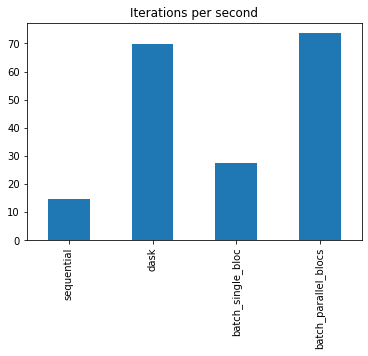

In [159]:
# pd.DataFrame(
pd.Series(iter_per_sec_stats).plot.bar(title='Iterations per second')

## Comparing options

In [161]:
if addresses.shape[0] > 500:
    addresses = addresses.sample(500)

In [162]:
# Single call
results = {}
it_per_seconds = []# pd.DataFrame()#columns = [ "mode", "check", "struct", "extra_hn"])
            
for mode, check_label, struct_label, extra_hn in tqdm([(m, c, s, h) for m in ["coordinates", "short", "long"]
                                            for c in ["check", "nocheck"]
                                            for s in ["struct", "unstruct"]
                                            for h in ["extrahn", "noextrahn"]
                                            ]):            
    print(mode, check_label, struct_label, extra_hn)
    start=datetime.now()

    results[(mode,  check_label, struct_label, extra_hn)] =  addresses.fillna("").apply(call_ws, 
                                                                              check_result=check_label == "check", 
                                                                              structured_osm=struct_label == "struct", 
                                                                              extra_house_number=extra_hn =="extrahn" ,
                                                                              with_rejected=False, 
                                                                              mode=mode,axis=1)

    it_per_seconds.append({"mode": mode,
                           "check": check_label,
                           "struct": struct_label,
                           "extra_hn": extra_hn,
                           "it_per_sec": addresses.shape[0] / (datetime.now()-start).total_seconds()})
    display(pd.DataFrame(it_per_seconds))
print("Iterations per seconds (single calls):")
it_per_seconds = pd.DataFrame(it_per_seconds)
it_per_seconds

  0%|          | 0/24 [00:00<?, ?it/s]

coordinates check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413


coordinates check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017


coordinates check unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156


coordinates check unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961


coordinates nocheck struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808


coordinates nocheck struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455


coordinates nocheck unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688


coordinates nocheck unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201


short check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944


short check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


short check unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


short check unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


short nocheck struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


short nocheck struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


short nocheck unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


short nocheck unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


long check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


long check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


long check unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


long check unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


long nocheck struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


long nocheck struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


long nocheck unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


long nocheck unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


Iterations per seconds (single calls):


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.120413
1,coordinates,check,struct,noextrahn,5.455017
2,coordinates,check,unstruct,extrahn,5.062156
3,coordinates,check,unstruct,noextrahn,5.223961
4,coordinates,nocheck,struct,extrahn,29.219808
5,coordinates,nocheck,struct,noextrahn,33.004455
6,coordinates,nocheck,unstruct,extrahn,22.910688
7,coordinates,nocheck,unstruct,noextrahn,24.602201
8,short,check,struct,extrahn,5.355944
9,short,check,struct,noextrahn,5.592667


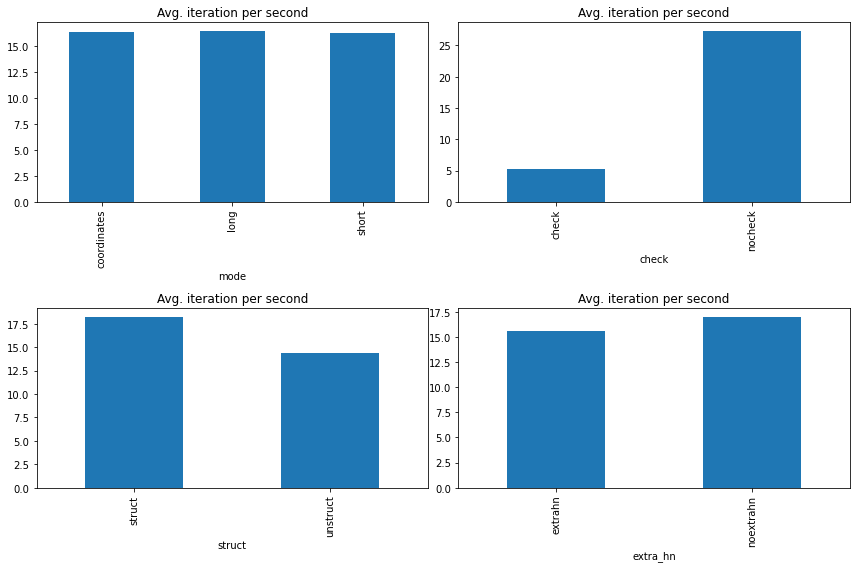

In [163]:
f, ax = plt.subplots(2,2, figsize=(12,8))
fl_ax=ax.flatten()
for i, fld in enumerate(it_per_seconds.drop("it_per_sec", axis=1).columns):
    it_per_seconds.groupby(fld).it_per_sec.mean().plot.bar(title="Avg. iteration per second", ax=fl_ax[i])
plt.tight_layout()
#     plt.show()

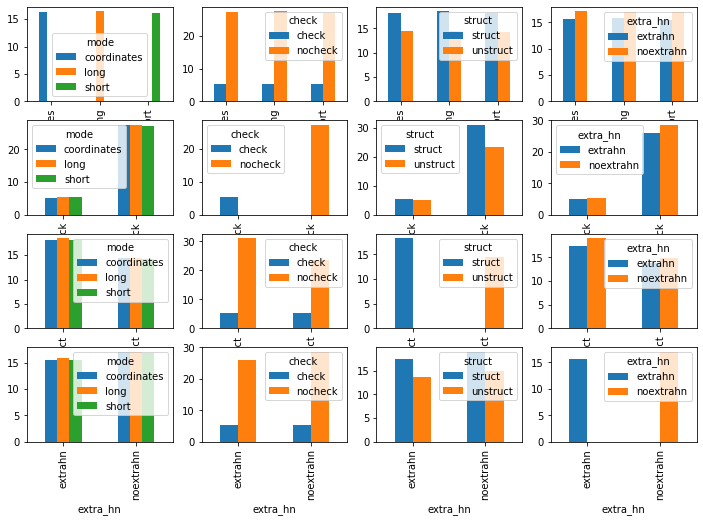

In [164]:
f, ax = plt.subplots(4,4, figsize=(12,8))
for i, fld1 in enumerate(it_per_seconds.drop("it_per_sec", axis=1).columns):
    for j, fld2 in enumerate(it_per_seconds.drop("it_per_sec", axis=1).columns):

        it_per_seconds.groupby([fld1, fld2]).it_per_sec.mean().unstack().plot.bar(ax=ax[i][j])

In [165]:
# results

In [166]:
# batch
batch_results = {}
batch_it_per_seconds = []# pd.DataFrame()#columns = [ "mode", "check", "struct", "extra_hn"])
            
for mode, check_label, struct_label, extra_hn in tqdm([(m, c, s, h) for m in ["coordinates", "short", "long"]
                                            for c in ["check", "nocheck"]
                                            for s in ["struct", "unstruct"]
                                            for h in ["extrahn", "noextrahn"]
                                            ]):            
    print(mode, check_label, struct_label, extra_hn)
    start=datetime.now()

    batch_results[(mode,  check_label, struct_label, extra_hn)] =  call_ws_batch(addresses,
                                                                              check_result=check_label == "check", 
                                                                              structured_osm=struct_label == "struct", 
                                                                              extra_house_number=extra_hn =="extrahn" ,
                                                                              with_rejected=False, 
                                                                              mode=mode)[0]

    batch_it_per_seconds.append({"mode": mode,
                           "check": check_label,
                           "struct": struct_label,
                           "extra_hn": extra_hn,
                           "it_per_sec": addresses.shape[0] / (datetime.now()-start).total_seconds()})
    display(pd.DataFrame(batch_it_per_seconds))
print("Iterations per seconds (batch calls):")
batch_it_per_seconds = pd.DataFrame(batch_it_per_seconds)
batch_it_per_seconds

  0%|          | 0/24 [00:00<?, ?it/s]

coordinates check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831


coordinates check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087


coordinates check unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474


coordinates check unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430


coordinates nocheck struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292


coordinates nocheck struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831


coordinates nocheck unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339


coordinates nocheck unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777


short check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867


short check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


short check unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


short check unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


short nocheck struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


short nocheck struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


short nocheck unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


short nocheck unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


long check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


long check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


long check unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


long check unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


long nocheck struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


long nocheck struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


long nocheck unstruct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


long nocheck unstruct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


Iterations per seconds (batch calls):


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,28.734831
1,coordinates,check,struct,noextrahn,28.700087
2,coordinates,check,unstruct,extrahn,23.973474
3,coordinates,check,unstruct,noextrahn,24.366430
4,coordinates,nocheck,struct,extrahn,45.198292
5,coordinates,nocheck,struct,noextrahn,44.172831
6,coordinates,nocheck,unstruct,extrahn,33.495339
7,coordinates,nocheck,unstruct,noextrahn,33.784777
8,short,check,struct,extrahn,26.600867
9,short,check,struct,noextrahn,29.406800


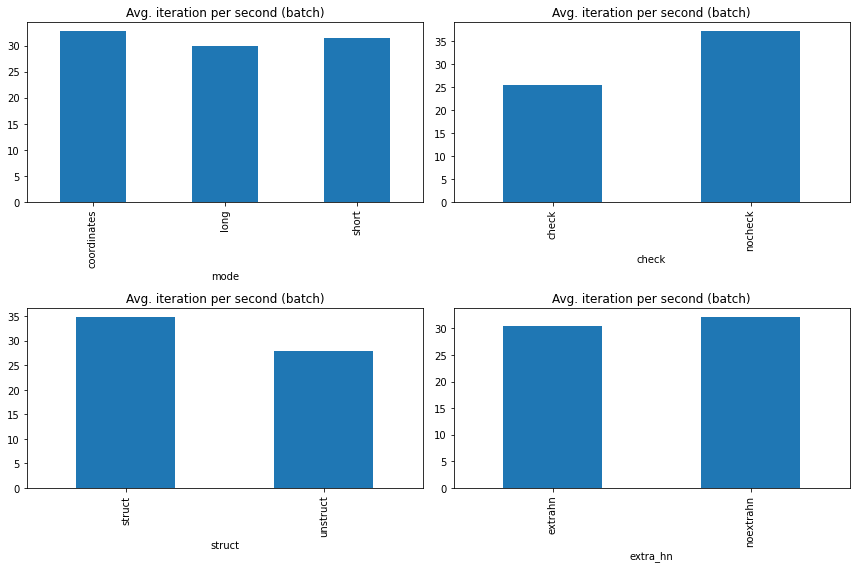

In [167]:
f, ax = plt.subplots(2,2, figsize=(12,8))
fl_ax=ax.flatten()
for i, fld in enumerate(batch_it_per_seconds.drop("it_per_sec", axis=1).columns):
    batch_it_per_seconds.groupby(fld).it_per_sec.mean().plot.bar(title="Avg. iteration per second (batch)", ax=fl_ax[i])
plt.tight_layout()

Match rate (without nostreet)


match_rate        
check         check nocheck
struct                     
struct          1.0     1.0
unstruct        1.0     1.0

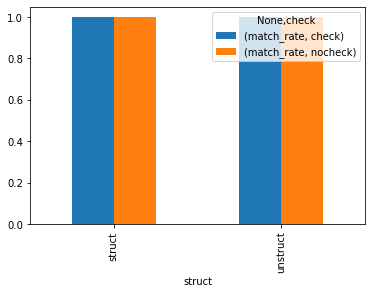

In [168]:
print("Match rate (without nostreet)")
mr=[]
for k1 in ["struct", "unstruct"]:
    for k2 in ["check", "nocheck"]:
        keys = [k for k in  batch_results.keys() if k1 in k and k2 in k]
        mr.append({"struct": k1, "check": k2, "match_rate": min([batch_results[k][batch_results[k][("metadata", "method")]!="nostreet" ].shape[0]/addresses.shape[0] for k in keys])})

mr = pd.DataFrame(mr).set_index(["struct","check" ]).unstack()

mr.plot.bar() 
mr